# Project: Communicate Data Findings
By: Christoph Lindstädt
## Table of Contents
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#questions">Posing Questions</a></li>
    <li><a href="#sources">Data Sources</a></li>
    <li><a href="#gathering">Data Gathering & Wrangling</a></li>
    <li><a href="#assessing">Data Assessing</a></li>
    <ul>
        <li><a href="#assessingsum">Assessing Summary</a></li>            
    </ul>    
    <li><a href="#cleaning">Data Cleaning</a></li>
    <li><a href="#analysis">Data Analysis</a></li>
    <ul>
        <li><a href="#uni">Univariate Exploration</a></li>
        <li><a href="#bi">Bivariate Exploration</a></li>
        <li><a href="#multi">Multivariate Exploration</a></li> 
    </ul> 
    <li><a href="#conclusion">Summary and Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

<a id='questions'></a>
## Posing Questions

The following analysis will take a look on the following questions:
><ol>
>    <li><p>Q1</p></li>     
>    <li><p>Q2</p></li>     
></ol>

<a id='sources'></a>
## Data Sources

>1. **Name:**</li>
><ul>   
>    <li><b>Source:</b> <a href =""></a></li>    
>    <li><b>Description:</b></li>
>    <li><b>Version:</b></li>
>    <li><b>Method of gathering:</b> Manual download</li>
></ul>


#### Import of the needed libraries:

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='gathering'></a>
## Data Gathering & Wrangling

In [68]:
files = [x for x in os.walk("./Data")][0][2]
month_range =  [int(x[:6]) for x in files]

result = pd.read_csv(f"./Data/{month_range[0]}-fordgobike-tripdata.csv")
len_df = len(result)

for i, month in enumerate(month_range):
    
    if i+2 > len(month_range):
        break
    
    else:    
        df_append  = pd.read_csv(f"./Data/{month_range[i+1]}-fordgobike-tripdata.csv")
        len_df += len(df_append)
        assert all(result.columns == df_append.columns)
        result = result.append(df_append)
        print(f"{month_range[i+1]}")
        
result.to_csv("result.csv", index = False)
print("Done")           
print(len_df == len(result))
del len_df, df_append, result, files, month_range

201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
201901
201902
Done
True


<a id='assessing'></a>
## Data Assessing

In [69]:
df = pd.read_csv("result.csv")

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239215 entries, 0 to 2239214
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 273.3+ MB


In [73]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,75284,2018-01-31 22:52:35.2390,2018-02-01 19:47:19.8240,120.0,Mission Dolores Park,37.761420,-122.426435,285.0,Webster St at O'Farrell St,37.783521,-122.431158,2765,Subscriber,1986.0,Male,No
1,85422,2018-01-31 16:13:34.3510,2018-02-01 15:57:17.3100,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,2815,Customer,NaN,NaN,No
2,71576,2018-01-31 14:23:55.8890,2018-02-01 10:16:52.1160,304.0,Jackson St at 5th St,37.348759,-121.894798,296.0,5th St at Virginia St,37.325998,-121.877120,3039,Customer,1996.0,Male,No
3,61076,2018-01-31 14:53:23.5620,2018-02-01 07:51:20.5000,75.0,Market St at Franklin St,37.773793,-122.421239,47.0,4th St at Harrison St,37.780955,-122.399749,321,Customer,NaN,NaN,No
4,39966,2018-01-31 19:52:24.6670,2018-02-01 06:58:31.0530,74.0,Laguna St at Hayes St,37.776435,-122.426244,19.0,Post St at Kearny St,37.788975,-122.403452,617,Subscriber,1991.0,Male,No


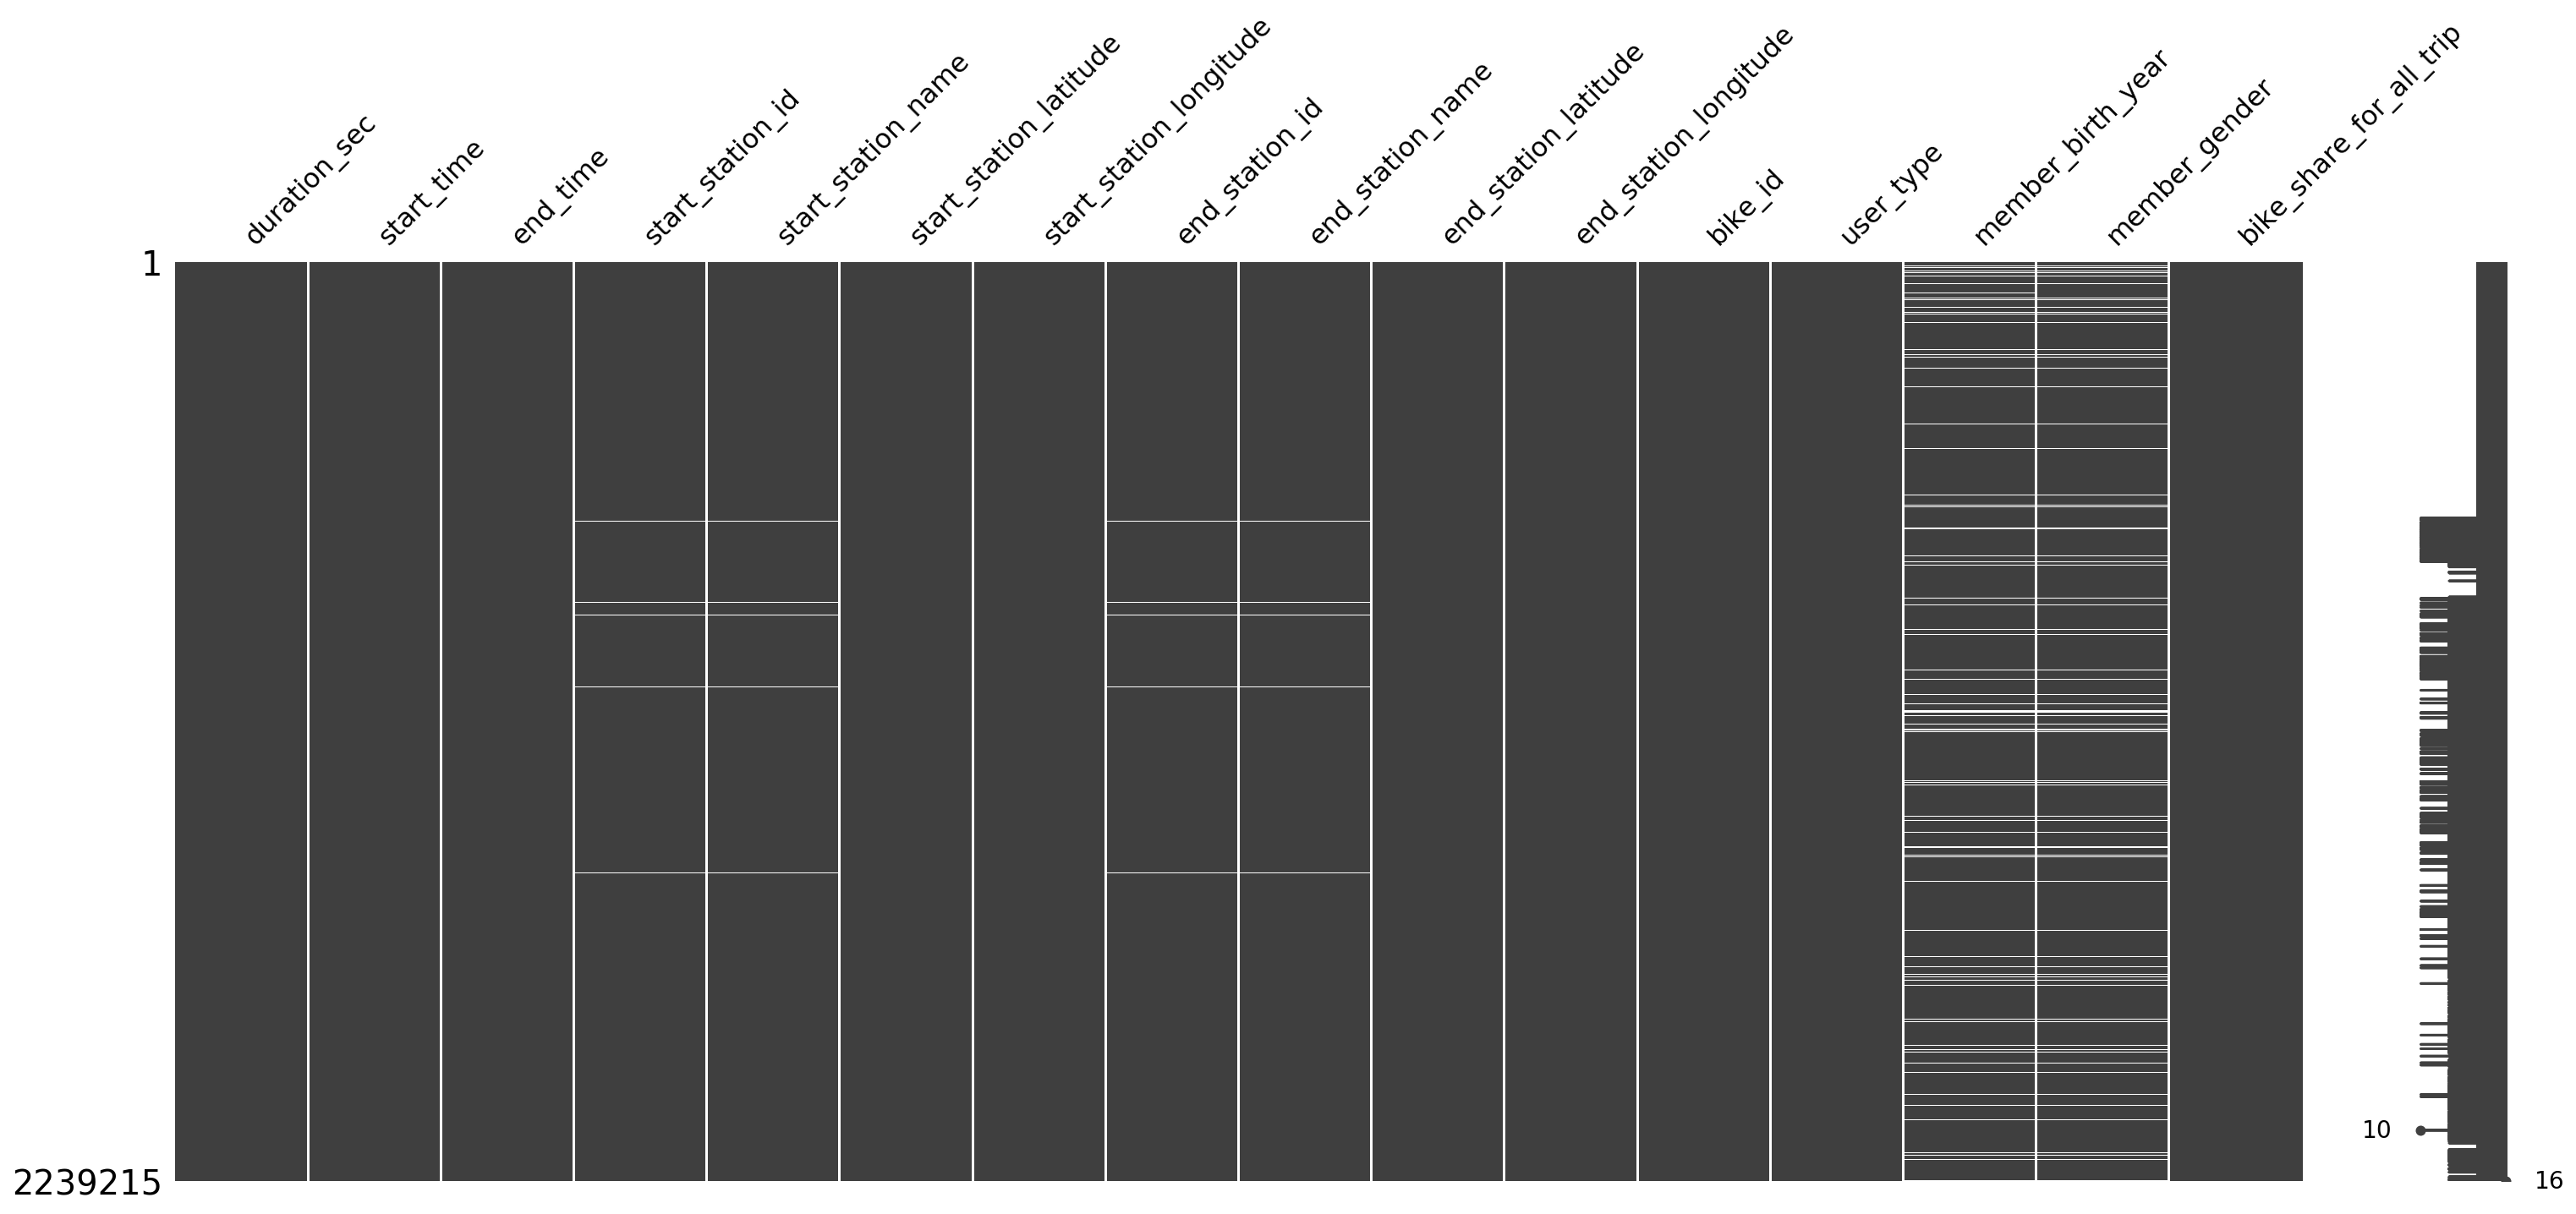

In [74]:
ms.matrix(df)

<a id='assessingsum'></a>
### Assessing Summary

#### Quality
##### "name" table
- quality issue


#### Tidiness
##### "name" table
- tidiness issue

<a id='cleaning'></a>
## Data Cleaning

### Issue #1
> #### Define #1
> Text describing the issue

> #### Clean #1

In [4]:
# Code

> #### Test #1

In [5]:
# Code

<a id='analysis'></a>
## Data Analysis

<a id='uni'></a>
### Univariate Exploration

> Distribution, unusual points, transformations, changes in data - why?

<a id='bi'></a>
### Bivariate Exploration
> Relationships

<a id='multi'></a>
### Multivariate Exploration
> Relationships

<a id='conclusion'></a>
## Summary and Conclusions

**Discussed questions:**
><ol>
>    <li><p><b>Question</b></p></li>
> Answer 
>    <li><p><b>Question</b></p></li>
> Answer
></ol>

**Limitations due to the cleaning process in the used datasets:**

><ol>
    ><li><p>Describing limitations to the original dataset</li>
></ol>

**Summary**
><ol>
>  Summary and Conclusions
</ol>